In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

\<user\>
\<url\>

Positive Smileys : <3 :p :') :d [: >:d < ^ - ^
Negative smileys : xd

"(" or ")" maybe come from ":((" or ":))" that became  "(" or ")" after removing ":(" or ":)"
Still need to check if "(" is followed by a ")" or not

Abbreviations : fr = for real

Maybe can try to use a tokenizer specific to Twitter


Some tweets are duplicated, x2, x3, x5 ...



# Loading DataSet

In [3]:
# Initialize empty lists to store the lines from the files
train_neg = []
train_pos = []

# File paths for the datasets
train_neg_file = 'twitter-datasets/train_neg.txt'
train_pos_file = 'twitter-datasets/train_pos.txt'

# Read lines from 'train_neg' dataset and store them in train_neg_lines
with open(train_neg_file, 'r', encoding='utf-8') as file:
    for line in file:
        train_neg.append(line.strip())  # Remove newline characters

# Read lines from 'train_pos' dataset and store them in train_pos_lines
with open(train_pos_file, 'r', encoding='utf-8') as file:
    for line in file:
        train_pos.append(line.strip())  # Remove newline characters

In [5]:
# Initialize empty lists to store the lines from the files
test = []

# File paths for the datasets
test_file = 'test_data.txt'

# Read lines from 'train_neg' dataset and store them in train_neg_lines
with open(test_file, 'r', encoding='utf-8') as file:
    for line in file:
        test.append(line.strip())  # Remove newline characters

In [6]:
import pandas as pd
import re
from os import listdir
from os.path import isfile, join
from random import shuffle

In [7]:
def create_dataframe(arr_pos, arr_neg):
    # Create a DataFrame from arr_pos with "value" column set to 1
    df_pos = pd.DataFrame({'text': arr_pos, 'label': 1})
    
    # Create a DataFrame from arr_neg with "value" column set to -1
    df_neg = pd.DataFrame({'text': arr_neg, 'label': 0})
    
    # Concatenate the two DataFrames
    result_df = pd.concat([df_pos, df_neg], ignore_index=True)
    
    return result_df

In [8]:
data_train = create_dataframe(train_pos, train_neg)

In [9]:
data_train

,text,label
0,<user> i dunno justin read my mention or not ....,1
1,"because your logic is so dumb , i won't even c...",1
2,""" <user> just put casper in a box ! "" looved t...",1
3,<user> <user> thanks sir > > don't trip lil ma...,1
4,visiting my brother tmr is the bestest birthda...,1
...,...,...
199995,can't wait to fake tan tonight ! hate being pale,0
199996,<user> darling i lost my internet connection ....,0
199997,kanguru defender basic 4 gb usb 2.0 flash driv...,0
199998,rizan is sad now,0


In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_train['text'], data_train['label'], test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Transform the text data into TF-IDF features
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a logistic regression model
model = LogisticRegression(max_iter=5000)
model.fit(X_train_tfidf, y_train)

# Predict labels for the test set
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("INITIAL ACCURACY:", accuracy)

INITIAL ACCURACY: 0.80635


# Parenthesis Management


In [11]:
def check_parentheses(s):
    """
    :type s: str
    :rtype: bool
    """
    count = 0
    for char in s:
        if char == '(':
            count += 1
        elif char == ')':
            if count == 0:
                return False
            count -= 1
    return count == 0

In [12]:
print(check_parentheses("This() is a (test)"))  # Expected output: True
print(check_parentheses("This is a test"))  # Expected output: True
print(check_parentheses("This is a (test"))  # Expected output: False
print(check_parentheses("This is a) test"))  # Expected output: False

True
True
False
False


In [14]:
def remove_parentheses(s):
    """
    :type s: str
    :rtype: str
    """
    result = ""
    i = 0
    while i < len(s):
        if s[i] == "(":
            j = i
            while j < len(s) and s[j] != ")":
                if s[j] == "(":
                    result += s[i:j]
                    i = j
                j += 1
            if j < len(s) and s[j] == ")":
                result += s[i+1:j]
                i = j + 1
            else:
                result += s[i]
                i += 1
        else:
            result += s[i]
            i += 1
    return result

In [15]:
print(remove_parentheses("This() is a (test)"))  # Expected output: "This is a test"
print(remove_parentheses("This is (a))) test"))  # Expected output: "This is a) test"
print(remove_parentheses("This is a (test"))  # Expected output: "This is a (test"
print(remove_parentheses("((This( is a) test"))  # Expected output: "(This is a test"


This is a test
This is a)) test
This is a (test
((This is a test


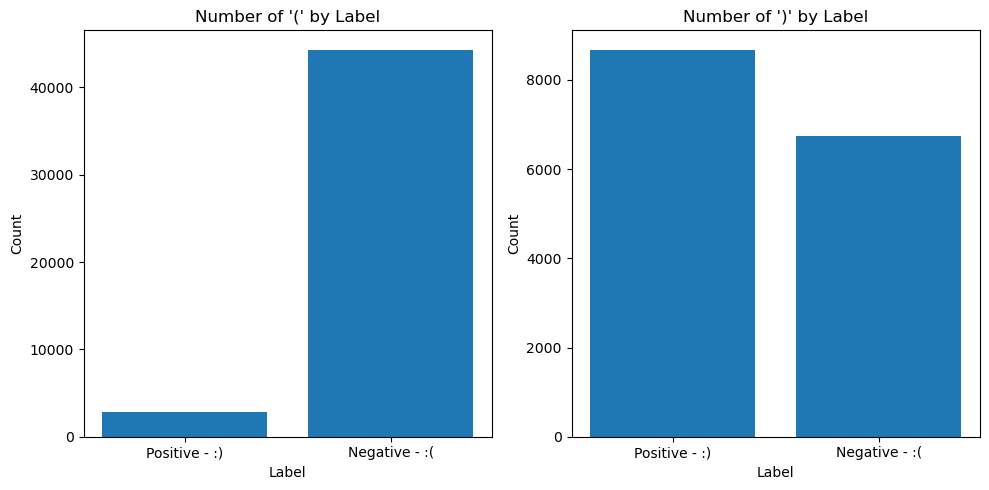

In [16]:
import matplotlib.pyplot as plt

# Count the number of '(' and ')' for each label
labels = ['Positive - :)', 'Negative - :(']

count_pos_open = data_train[data_train['label'] == 1]['text'].str.count('\(').sum()
count_neg_open = data_train[data_train['label'] == 0]['text'].str.count('\(').sum()
count_pos_close = data_train[data_train['label'] == 1]['text'].str.count('\)').sum()
count_neg_close = data_train[data_train['label'] == 0]['text'].str.count('\)').sum()

counts_open = [count_pos_open, count_neg_open]
counts_close = [count_pos_close, count_neg_close]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot counts of '('
ax1.bar(labels, counts_open, label='(')
ax1.set_xlabel('Label')
ax1.set_ylabel('Count')
ax1.set_title("Number of '(' by Label")

# Plot counts of ')'
ax2.bar(labels, counts_close, label=')')

ax2.set_xlabel('Label')
ax2.set_ylabel('Count')
ax2.set_title("Number of ')' by Label")

# Display the subplots
plt.tight_layout()

plt.show()


In [24]:
# Apply remove_tags to the 'text' column. We apply it 3 times in case there are nested parentheses
data_train_parenthesis_mng = data_train.copy()
data_train_parenthesis_mng['text'] = data_train_parenthesis_mng['text'].apply(remove_parentheses)
data_train_parenthesis_mng['text'] = data_train_parenthesis_mng['text'].apply(remove_parentheses)
data_train_parenthesis_mng['text'] = data_train_parenthesis_mng['text'].apply(remove_parentheses)
data_train_parenthesis_mng['text'] = data_train_parenthesis_mng['text'].apply(remove_parentheses)

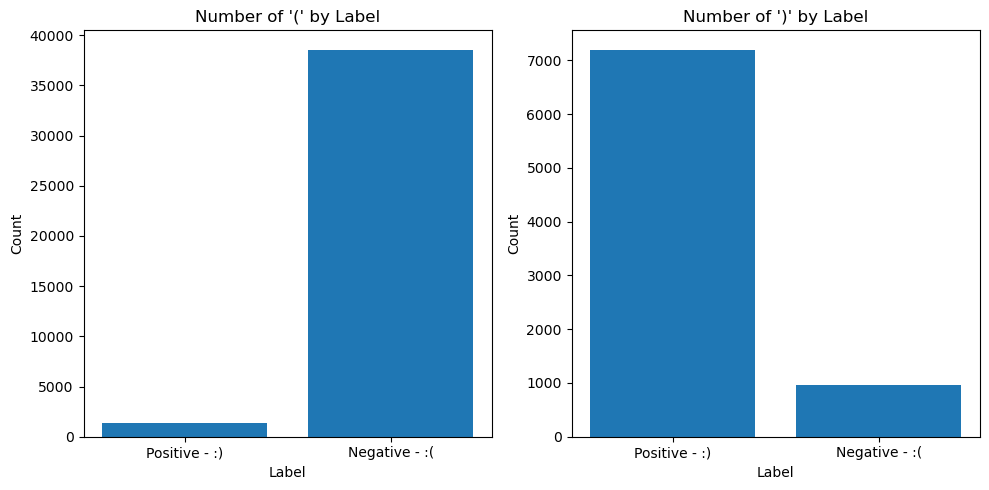

':((('

In [25]:
import matplotlib.pyplot as plt

# Count the number of '(' and ')' for each label
labels = ['Positive - :)', 'Negative - :(']

count_pos_open = data_train_parenthesis_mng[data_train_parenthesis_mng['label'] == 1]['text'].str.count('\(').sum()
count_neg_open = data_train_parenthesis_mng[data_train_parenthesis_mng['label'] == 0]['text'].str.count('\(').sum()
count_pos_close = data_train_parenthesis_mng[data_train_parenthesis_mng['label'] == 1]['text'].str.count('\)').sum()
count_neg_close = data_train_parenthesis_mng[data_train_parenthesis_mng['label'] == 0]['text'].str.count('\)').sum()

counts_open = [count_pos_open, count_neg_open]
counts_close = [count_pos_close, count_neg_close]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot counts of '('
ax1.bar(labels, counts_open, label='(')
ax1.set_xlabel('Label')
ax1.set_ylabel('Count')
ax1.set_title("Number of '(' by Label")

# Plot counts of ')'
ax2.bar(labels, counts_close, label=')')

ax2.set_xlabel('Label')
ax2.set_ylabel('Count')
ax2.set_title("Number of ')' by Label")

# Display the subplots
plt.tight_layout()

plt.show()

":)"
":((("

In [26]:
print(count_neg_open/(count_neg_close+count_neg_open))
print(count_pos_close/(count_pos_close+count_pos_open))
#expected : 0.9754548445051747
#expected : 0.8422653873157032

0.9754548445051747
0.8422653873157032


In [154]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_train_parenthesis_mng['text'], data_train_parenthesis_mng['label'], test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Transform the text data into TF-IDF features
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a logistic regression model
model = LogisticRegression(max_iter=5000)
model.fit(X_train_tfidf, y_train)

# Predict labels for the test set
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.80635


In [71]:
import numpy as np

y_pred_parenthesis = X_test.apply(lambda x: 0 if '(' in x else 1 if ')' in x else None)
#y_pred_parenthesis = X_test.apply(lambda x: 0 if '(' in x else None)


num_nans = y_pred_parenthesis.isna().sum()
print("NaNs in y_pred_parenthesis:", num_nans/len(y_pred_parenthesis))


# Create a boolean mask for NaN values in y_pred_parenthesis
nan_mask = y_pred_parenthesis.isna()

# Create a boolean mask for non-NaN values in y_pred_parenthesis
not_nan_mask = ~nan_mask

# Ensure that the length of y_pred is sufficient to replace NaNs
y_pred_parenthesis[~not_nan_mask] = y_pred[~not_nan_mask]

# Calculate accuracy
accuracy = accuracy_score(y_test,y_pred_parenthesis)
print("Accuracy y_pred_parenthesis:", accuracy)
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy y_pred:", accuracy)
accuracy = accuracy_score(y_test[~nan_mask],y_pred_parenthesis[~nan_mask])
print("Accuracy y_pred:", accuracy)

NaNs in y_pred_parenthesis: 0.778375
Accuracy y_pred_parenthesis: 0.8088
Accuracy y_pred: 0.80635
Accuracy y_pred: 0.9232938522278624


# Removing Duplicates

In [51]:
data_train_no_duplicates = data_train.drop_duplicates()

# number of duplicates
print("Number of duplicates:", len(data_train) - len(data_train_no_duplicates))


Number of duplicates: 229518


In [52]:
data_train_no_duplicates

,text,label
0,<user> i dunno justin read my mention or not ....,1
1,"because your logic is so dumb , i won't even c...",1
2,""" <user> just put casper in a box ! "" looved t...",1
3,<user> <user> thanks sir > > don't trip lil ma...,1
4,visiting my brother tmr is the bestest birthda...,1
...,...,...
2499995,im so sorry ! <user> & to <user> & <user> u gu...,0
2499996,i can't find food coloring anywhere,0
2499997,<user> same here ! ! but tort ! ! wonder why y...,0
2499998,keyless entry remote fob clicker for 2005 buic...,0


In [53]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_train_no_duplicates['text'], data_train_no_duplicates['label'], test_size=0.01, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Transform the text data into TF-IDF features
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a logistic regression model
model = LogisticRegression(max_iter=5000)
model.fit(X_train_tfidf, y_train)

# Predict labels for the test set
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("ACCURACY WITHOUT DUPLICATES:", accuracy)

ACCURACY WITHOUT DUPLICATES: 0.8126844307421273


In [54]:
test_data = []
with open("test_data.txt", 'r', encoding='utf-8') as file:
    for line in file:
        test_data.append(line.strip())  # Remove newline characters

test_data = pd.DataFrame({'text': test_data})

y_test_pred = model.predict(vectorizer.transform(test_data['text']))

In [55]:
import numpy as np
indexes = np.arange(1, len(y_test_pred)+1)  

y_test_pred_2 = np.where(y_test_pred == 0, -1, y_test_pred)

submission = pd.DataFrame({'Id':indexes,'Prediction': y_test_pred_2})

submission.to_csv('test_predictions.csv', index=False)

# Remove \<user\> and \<url\>

In [56]:
#Remove all the words in < > and the < > themselves
def remove_tags(text):
    """
    :type text: str
    :rtype: str
    """
    return re.sub('<[^>]*>', '', text)

In [69]:
# Apply remove_tags to the 'text' column
data_train_no_symbols = data_train.copy()
data_train_no_symbols['text'] = data_train_no_symbols['text'].apply(remove_tags)

In [65]:
# Remove all the special characters except for parentheses ()
def remove_special_characters(text):
    """
    :type text: str
    :rtype: str
    """
    return re.sub('[^a-zA-Z\s()]', '', text)


In [67]:
data_train_no_symbols['text'] = data_train_no_symbols['text'].apply(remove_special_characters)

In [70]:
data_train_no_symbols

,text,label
0,i dunno justin read my mention or not . only ...,1
1,"because your logic is so dumb , i won't even c...",1
2,""" just put casper in a box ! "" looved the bat...",1
3,thanks sir > > don't trip lil mama ... just ...,1
4,visiting my brother tmr is the bestest birthda...,1
...,...,...
2499995,im so sorry ! & to & u guys are ridiculous ...,0
2499996,i can't find food coloring anywhere,0
2499997,same here ! ! but tort ! ! wonder why you cho...,0
2499998,keyless entry remote fob clicker for 2005 buic...,0


In [68]:
data_train_no_symbols.to_csv('data_train_no_symbols.csv', index=False)


# Results


Training Set : Initial Accuracy : 0.81912 | Accuracy without duplicates : 0.81268

Test Set : Initial Accuracy : 0.818 | Accuracy without duplicates : 0.820

Increase by 0.2% on Test Set

Overfitting is happening on the Training set as expected